In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr
from sklearn import preprocessing
from sklearn.decomposition import PCA 
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split,cross_val_score
import xgboost as xgb

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
data_path='/content/drive/My Drive/Projects/Hackathons/Power Plant Energy Prediction/Train.csv'

In [ ]:
data=pd.read_csv(data_path)

In [ ]:
data.head(2)

,AT,V,AP,RH,PE
0,29.07,72.51,1009.24,58.38,449.371855
1,32.38,67.17,1006.97,60.04,450.861043


In [ ]:
data.shape

(9568, 5)

In [ ]:
data.isnull().sum()

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

In [ ]:
for col in data.columns:
    InterQuartileRange=iqr(data[col])
    print('InterQuartileRange for',col,' =',InterQuartileRange)
    InterQuartileRangeLower=np.quantile(data[col], .25)
    print('InterQuartileRangeLower for',col,' =',InterQuartileRangeLower)
    InterQuartileRangeHigher=np.quantile(data[col], .75)
    print('InterQuartileRangeHigher for ',col,' =',InterQuartileRangeHigher)
    print('Max of ',col,' =',data[col].max())
    print('Min of ',col,' =',data[col].min())
    print('Lower Limit for ',col,' =',InterQuartileRangeLower-(1.5*InterQuartileRange))
    print('Upper Limit ',col,' =',InterQuartileRangeHigher+(1.5*InterQuartileRange))
    InRange=0
    OutRange=0
    for i in data[col]:
        if((InterQuartileRangeLower-(1.5*InterQuartileRange))<=i<=(InterQuartileRangeHigher+(1.5*InterQuartileRange))):
            InRange=InRange+1
        else:
            OutRange=OutRange+1
    print('InRange for ',col,' =',InRange)
    print('OutRange for ',col,' =',OutRange)

InterQuartileRange for AT  = 12.209999999999999
InterQuartileRangeLower for AT  = 13.56
InterQuartileRangeHigher for  AT  = 25.77
Max of  AT  = 37.11
Min of  AT  = 2.34
Lower Limit for  AT  = -4.754999999999997
Upper Limit  AT  = 44.084999999999994
InRange for  AT  = 9568
OutRange for  AT  = 0
InterQuartileRange for V  = 24.78
InterQuartileRangeLower for V  = 41.78
InterQuartileRangeHigher for  V  = 66.56
Max of  V  = 81.56
Min of  V  = 25.36
Lower Limit for  V  = 4.609999999999999
Upper Limit  V  = 103.73
InRange for  V  = 9568
OutRange for  V  = 0
InterQuartileRange for AP  = 8.132499999999936
InterQuartileRangeLower for AP  = 1009.21
InterQuartileRangeHigher for  AP  = 1017.3425
Max of  AP  = 1033.3
Min of  AP  = 993.11
Lower Limit for  AP  = 997.0112500000001
Upper Limit  AP  = 1029.5412499999998
InRange for  AP  = 9497
OutRange for  AP  = 71
InterQuartileRange for RH  = 21.800000000000004
InterQuartileRangeLower for RH  = 62.99
InterQuartileRangeHigher for  RH  = 84.79
Max of  RH 

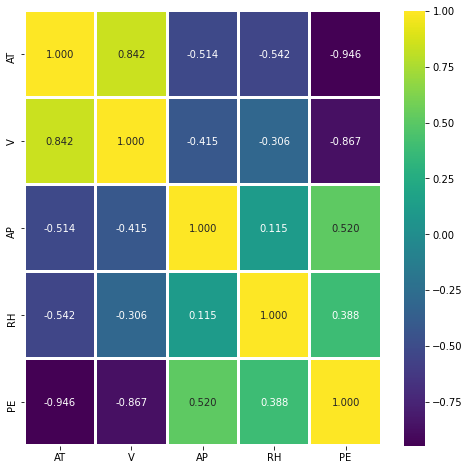

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(data.corr(),annot=True,cmap='viridis',fmt='.3f',linewidths=2)
plt.show()

In [ ]:
x=data.loc[:, data.columns != 'PE']
y=data['PE']

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size = 0.33, random_state = 20)

In [ ]:
#Standardizing training data
scaler = preprocessing.StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)

In [ ]:
#Standardizing testing data
X_test_scaled=scaler.transform(X_test)

In [ ]:
#Normalizing training data
X_train_norm = preprocessing.normalize(X_train)

In [ ]:
#Normalizing training data
X_test_norm = preprocessing.normalize(X_test)

In [ ]:
#Declaring these for comparision between models
predictions=pd.DataFrame()
MeanAbsoluteError_dict={}
MeanSquaredError_dict={}
RootMeanSquaredError_dict={}
R2Score_dict={}
TestR2Score_dict={}
CrossValScore_dict={}

In [ ]:
def consolidator(modelInstance,ModelName,X_train,Y_train,X_test,Y_test,Y_Pred):
  predictions[ModelName] = Y_Pred

  print(ModelName,'Model:-')

  R2Score = modelInstance.score(X_train, Y_train)
  TestR2Score = modelInstance.score(X_test, Y_test)
  MeanAbsErr = mean_absolute_error(Y_test, Y_Pred)
  MeanSqErr =  mean_squared_error(Y_test, Y_Pred)
  RootMeanSqErr = np.sqrt(mean_squared_error(Y_test, Y_Pred))
  
  print("R^2 Score: ", R2Score)
  print("Test R^2 Score: ", TestR2Score)
  print('Mean Absolute Error :', MeanAbsErr)  
  print('Mean Squared Error :', MeanSqErr)  
  print('Root Mean Squared Error :', RootMeanSqErr)

  R2Score_dict[ModelName] = R2Score
  TestR2Score_dict[ModelName] = TestR2Score
  MeanAbsoluteError_dict[ModelName] =  MeanAbsErr
  MeanSquaredError_dict[ModelName] = MeanSqErr
  RootMeanSquaredError_dict[ModelName] = RootMeanSqErr

#Linear Regression Original

In [ ]:
LR = LinearRegression()
param_grid = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

grid_search = GridSearchCV(estimator = LR, param_grid = param_grid,cv=3,verbose=2)
LR_GS = grid_search.fit(X_train, Y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] copy_X=True, fit_intercept=True, normalize=True .................
[CV] .. copy_X=True, fit_intercept=True, normalize=True, total=   0.0s
[CV] copy_X=True, fit_intercept=True, normalize=True .................
[CV] .. copy_X=True, fit_intercept=True, normalize=True, total=   0.0s
[CV] copy_X=True, fit_intercept=True, normalize=True .................
[CV] .. copy_X=True, fit_intercept=True, normalize=True, total=   0.0s
[CV] copy_X=True, fit_intercept=True, normalize=False ................
[CV] . copy_X=True, fit_intercept=True, normalize=False, total=   0.0s
[CV] copy_X=True, fit_intercept=True, normalize=False ................
[CV] . copy_X=True, fit_intercept=True, normalize=False, total=   0.0s
[CV] copy_X=True, fit_intercept=True, normalize=False ................
[CV] . copy_X=True, fit_intercept=True, normalize=False, total=   0.0s
[CV] copy_X=True, fit_intercept=False, normalize=True ................
[CV] . copy_X=Tru

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.2s finished


In [ ]:
LR_GS.best_estimator_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [ ]:
Y_pred_LR = LR_GS.predict(X_test)

In [ ]:
consolidator(LR_GS,'LR_Orignial',X_train,Y_train,X_test,Y_test,Y_pred_LR)

LR_Orignial Model:-
R^2 Score:  0.9241474160922808
Test R^2 Score:  0.9277912046349331
Mean Absolute Error : 3.692171922700235
Mean Squared Error : 20.746679614723245
Root Mean Squared Error : 4.554852315358122


# Linear Regression Scaled

In [ ]:
LR = LinearRegression()
param_grid = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

grid_search = GridSearchCV(estimator = LR, param_grid = param_grid,cv=3,verbose=2)
LR_GS = grid_search.fit(X_train_scaled, Y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] copy_X=True, fit_intercept=True, normalize=True .................
[CV] .. copy_X=True, fit_intercept=True, normalize=True, total=   0.0s
[CV] copy_X=True, fit_intercept=True, normalize=True .................
[CV] .. copy_X=True, fit_intercept=True, normalize=True, total=   0.0s
[CV] copy_X=True, fit_intercept=True, normalize=True .................
[CV] .. copy_X=True, fit_intercept=True, normalize=True, total=   0.0s
[CV] copy_X=True, fit_intercept=True, normalize=False ................
[CV] . copy_X=True, fit_intercept=True, normalize=False, total=   0.0s
[CV] copy_X=True, fit_intercept=True, normalize=False ................
[CV] . copy_X=True, fit_intercept=True, normalize=False, total=   0.0s
[CV] copy_X=True, fit_intercept=True, normalize=False ................
[CV] . copy_X=True, fit_intercept=True, normalize=False, total=   0.0s
[CV] copy_X=True, fit_intercept=False, normalize=True ................
[CV] . copy_X=Tru

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished


In [ ]:
LR_GS.best_estimator_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [ ]:
Y_pred_LR = LR_GS.predict(X_test_scaled)

In [ ]:
consolidator(LR_GS,'LR_Scaled',X_train_scaled,Y_train,X_test_scaled,Y_test,Y_pred_LR)

LR_Scaled Model:-
R^2 Score:  0.9241474160922808
Test R^2 Score:  0.9277912046349331
Mean Absolute Error : 3.6921719227002345
Mean Squared Error : 20.74667961472326
Root Mean Squared Error : 4.554852315358124


# Linear Regression Normalized

In [ ]:
LR = LinearRegression()
param_grid = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

grid_search = GridSearchCV(estimator = LR, param_grid = param_grid,cv=3,verbose=2)
LR_GS = grid_search.fit(X_train_norm, Y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] copy_X=True, fit_intercept=True, normalize=True .................
[CV] .. copy_X=True, fit_intercept=True, normalize=True, total=   0.0s
[CV] copy_X=True, fit_intercept=True, normalize=True .................
[CV] .. copy_X=True, fit_intercept=True, normalize=True, total=   0.0s
[CV] copy_X=True, fit_intercept=True, normalize=True .................
[CV] .. copy_X=True, fit_intercept=True, normalize=True, total=   0.0s
[CV] copy_X=True, fit_intercept=True, normalize=False ................
[CV] . copy_X=True, fit_intercept=True, normalize=False, total=   0.0s
[CV] copy_X=True, fit_intercept=True, normalize=False ................
[CV] . copy_X=True, fit_intercept=True, normalize=False, total=   0.0s
[CV] copy_X=True, fit_intercept=True, normalize=False ................
[CV] . copy_X=True, fit_intercept=True, normalize=False, total=   0.0s
[CV] copy_X=True, fit_intercept=False, normalize=True ................
[CV] . copy_X=Tru

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.1s finished


In [ ]:
LR_GS.best_estimator_

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
Y_pred_LR = LR_GS.predict(X_test_norm)

In [ ]:
consolidator(LR_GS,'LR_Norm',X_train_norm,Y_train,X_test_norm,Y_test,Y_pred_LR)

LR_Norm Model:-
R^2 Score:  0.9252520952296821
Test R^2 Score:  0.9289573883898156
Mean Absolute Error : 3.669822556791122
Mean Squared Error : 20.41161737456095
Root Mean Squared Error : 4.5179217981900655


# XG Boost Regression Original

In [ ]:
XGR = xgb.XGBRegressor()
param_grid = {"objective":['reg:squarederror'],
              'colsample_bytree': [0.7],
              'learning_rate': [0.001,0.01,0.1,1],
              'max_depth': [10], 
              'alpha': [1], 
              'n_estimators':[500,1000,1500,2000,2500]}

grid_search = GridSearchCV(estimator = XGR, param_grid = param_grid,cv=3, verbose=2)
XGR_GS = grid_search.fit(X_train, Y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=500, objective=reg:squarederror 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=500, objective=reg:squarederror, total=   0.7s
[CV] alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=500, objective=reg:squarederror 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s


[CV]  alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=500, objective=reg:squarederror, total=   0.5s
[CV] alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=500, objective=reg:squarederror 
[CV]  alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=500, objective=reg:squarederror, total=   0.6s
[CV] alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=1000, objective=reg:squarederror 
[CV]  alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=1000, objective=reg:squarederror, total=   1.2s
[CV] alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=1000, objective=reg:squarederror 
[CV]  alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=1000, objective=reg:squarederror, total=   1.2s
[CV] alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=1000, objective=reg:squarederror 

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.6min finished


In [ ]:
XGR_GS.best_estimator_

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
Y_pred_XGR = XGR_GS.predict(X_test)

In [ ]:
consolidator(XGR_GS,'XGBR_Original',X_train,Y_train,X_test,Y_test,Y_pred_XGR)

XGBR_Original Model:-
R^2 Score:  0.9969049705778318
Test R^2 Score:  0.9757766878860032
Mean Absolute Error : 1.9296070575033866
Mean Squared Error : 6.959724131884074
Root Mean Squared Error : 2.6381289073667484


# XG Boost Regression Scaled

In [ ]:
XGR = xgb.XGBRegressor()
param_grid = {"objective":['reg:squarederror'],
              'colsample_bytree': [0.7],
              'learning_rate': [0.001,0.01,0.1,1],
              'max_depth': [10], 
              'alpha': [1], 
              'n_estimators':[500,1000,1500,2000,2500]}

grid_search = GridSearchCV(estimator = XGR, param_grid = param_grid,cv=3, verbose=2)
XGR_GS = grid_search.fit(X_train_scaled, Y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=500, objective=reg:squarederror 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=500, objective=reg:squarederror, total=   0.5s
[CV] alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=500, objective=reg:squarederror 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s


[CV]  alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=500, objective=reg:squarederror, total=   0.5s
[CV] alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=500, objective=reg:squarederror 
[CV]  alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=500, objective=reg:squarederror, total=   0.5s
[CV] alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=1000, objective=reg:squarederror 
[CV]  alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=1000, objective=reg:squarederror, total=   1.1s
[CV] alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=1000, objective=reg:squarederror 
[CV]  alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=1000, objective=reg:squarederror, total=   1.1s
[CV] alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=1000, objective=reg:squarederror 

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.6min finished


In [ ]:
XGR_GS.best_estimator_

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
Y_pred_XGR = XGR_GS.predict(X_test_scaled)

In [ ]:
consolidator(XGR_GS,'XGBR_scaled',X_train_scaled,Y_train,X_test_scaled,Y_test,Y_pred_XGR)

XGBR_scaled Model:-
R^2 Score:  0.9969049705778318
Test R^2 Score:  0.9758110551885268
Mean Absolute Error : 1.9293099386484052
Mean Squared Error : 6.949849885802642
Root Mean Squared Error : 2.636256794358744


# XG Boost Normalize

In [ ]:
XGR = xgb.XGBRegressor()
param_grid = {"objective":['reg:squarederror'],
              'colsample_bytree': [0.7],
              'learning_rate': [0.001,0.01,0.1,1],
              'max_depth': [10], 
              'alpha': [1], 
              'n_estimators':[500,1000,1500,2000,2500]}

grid_search = GridSearchCV(estimator = XGR, param_grid = param_grid,cv=3, verbose=2)
XGR_GS = grid_search.fit(X_train_norm, Y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=500, objective=reg:squarederror 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=500, objective=reg:squarederror, total=   0.5s
[CV] alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=500, objective=reg:squarederror 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=500, objective=reg:squarederror, total=   0.5s
[CV] alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=500, objective=reg:squarederror 
[CV]  alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=500, objective=reg:squarederror, total=   0.5s
[CV] alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=1000, objective=reg:squarederror 
[CV]  alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=1000, objective=reg:squarederror, total=   1.2s
[CV] alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=1000, objective=reg:squarederror 
[CV]  alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=1000, objective=reg:squarederror, total=   1.2s
[CV] alpha=1, colsample_bytree=0.7, learning_rate=0.001, max_depth=10, n_estimators=1000, objective=reg:squarederror 

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.8min finished


In [ ]:
XGR_GS.best_estimator_

XGBRegressor(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=2500,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
Y_pred_XGR = XGR_GS.predict(X_test_norm)

In [ ]:
consolidator(XGR_GS,'XGBR_norm',X_train_norm,Y_train,X_test_norm,Y_test,Y_pred_XGR)

XGBR_norm Model:-
R^2 Score:  0.9948624541890114
Test R^2 Score:  0.9662130454580046
Mean Absolute Error : 2.264695991286747
Mean Squared Error : 9.707503324160307
Root Mean Squared Error : 3.115686653718616


# Ada Boost Regression Original

In [ ]:
ABR = AdaBoostRegressor()
param_grid = {'n_estimators': [500,1000,2000,2500],
             'learning_rate': [0.001,0.01,0.1,1]}

grid_search = GridSearchCV(estimator = ABR, param_grid = param_grid,cv=3,verbose=2)
ABR_GS = grid_search.fit(X_train, Y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] learning_rate=0.001, n_estimators=500 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............ learning_rate=0.001, n_estimators=500, total=   3.9s
[CV] learning_rate=0.001, n_estimators=500 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s


[CV] ............ learning_rate=0.001, n_estimators=500, total=   3.8s
[CV] learning_rate=0.001, n_estimators=500 ...........................
[CV] ............ learning_rate=0.001, n_estimators=500, total=   3.8s
[CV] learning_rate=0.001, n_estimators=1000 ..........................
[CV] ........... learning_rate=0.001, n_estimators=1000, total=   7.6s
[CV] learning_rate=0.001, n_estimators=1000 ..........................
[CV] ........... learning_rate=0.001, n_estimators=1000, total=   7.5s
[CV] learning_rate=0.001, n_estimators=1000 ..........................
[CV] ........... learning_rate=0.001, n_estimators=1000, total=   7.6s
[CV] learning_rate=0.001, n_estimators=2000 ..........................
[CV] ........... learning_rate=0.001, n_estimators=2000, total=  15.0s
[CV] learning_rate=0.001, n_estimators=2000 ..........................
[CV] ........... learning_rate=0.001, n_estimators=2000, total=  15.1s
[CV] learning_rate=0.001, n_estimators=2000 ..........................
[CV] .

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  4.6min finished


In [ ]:
ABR_GS.best_estimator_

AdaBoostRegressor(base_estimator=None, learning_rate=0.01, loss='linear',
                  n_estimators=500, random_state=None)

In [ ]:
Y_pred_ABR = ABR_GS.predict(X_test)

In [ ]:
consolidator(ABR_GS,'AdaR_Original',X_train,Y_train,X_test,Y_test,Y_pred_ABR)

AdaR_Original Model:-
R^2 Score:  0.918586059470375
Test R^2 Score:  0.9148019908830246
Mean Absolute Error : 3.9383006015862954
Mean Squared Error : 24.478677286136747
Root Mean Squared Error : 4.947593080088211


# Ada Boost Regression Scaled

In [ ]:
ABR = AdaBoostRegressor()
param_grid = {'n_estimators': [500,1000,2000,2500],
             'learning_rate': [0.001,0.01,0.1,1]}

grid_search = GridSearchCV(estimator = ABR, param_grid = param_grid,cv=3,verbose=2)
ABR_GS = grid_search.fit(X_train_scaled, Y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] learning_rate=0.001, n_estimators=500 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............ learning_rate=0.001, n_estimators=500, total=   3.8s
[CV] learning_rate=0.001, n_estimators=500 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s


[CV] ............ learning_rate=0.001, n_estimators=500, total=   3.8s
[CV] learning_rate=0.001, n_estimators=500 ...........................
[CV] ............ learning_rate=0.001, n_estimators=500, total=   3.8s
[CV] learning_rate=0.001, n_estimators=1000 ..........................
[CV] ........... learning_rate=0.001, n_estimators=1000, total=   7.6s
[CV] learning_rate=0.001, n_estimators=1000 ..........................
[CV] ........... learning_rate=0.001, n_estimators=1000, total=   7.6s
[CV] learning_rate=0.001, n_estimators=1000 ..........................
[CV] ........... learning_rate=0.001, n_estimators=1000, total=   7.7s
[CV] learning_rate=0.001, n_estimators=2000 ..........................
[CV] ........... learning_rate=0.001, n_estimators=2000, total=  14.9s
[CV] learning_rate=0.001, n_estimators=2000 ..........................
[CV] ........... learning_rate=0.001, n_estimators=2000, total=  15.1s
[CV] learning_rate=0.001, n_estimators=2000 ..........................
[CV] .

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  4.7min finished


In [ ]:
ABR_GS.best_estimator_

AdaBoostRegressor(base_estimator=None, learning_rate=0.01, loss='linear',
                  n_estimators=500, random_state=None)

In [ ]:
Y_pred_ABR = ABR_GS.predict(X_test_scaled)

In [ ]:
consolidator(ABR_GS,'AdaR_scaled',X_train_scaled,Y_train,X_test_scaled,Y_test,Y_pred_ABR)

AdaR_scaled Model:-
R^2 Score:  0.9186623101030781
Test R^2 Score:  0.9149259179690079
Mean Absolute Error : 3.9339735900715844
Mean Squared Error : 24.44307115899555
Root Mean Squared Error : 4.943993442450703


# Ada Boost Regression Norm

In [ ]:
ABR = AdaBoostRegressor()
param_grid = {'n_estimators': [500,1000,2000,2500],
             'learning_rate': [0.001,0.01,0.1,1]}

grid_search = GridSearchCV(estimator = ABR, param_grid = param_grid,cv=3,verbose=2)
ABR_GS = grid_search.fit(X_train_norm, Y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] learning_rate=0.001, n_estimators=500 ...........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............ learning_rate=0.001, n_estimators=500, total=   4.2s
[CV] learning_rate=0.001, n_estimators=500 ...........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.2s remaining:    0.0s


[CV] ............ learning_rate=0.001, n_estimators=500, total=   4.0s
[CV] learning_rate=0.001, n_estimators=500 ...........................
[CV] ............ learning_rate=0.001, n_estimators=500, total=   4.1s
[CV] learning_rate=0.001, n_estimators=1000 ..........................
[CV] ........... learning_rate=0.001, n_estimators=1000, total=   8.1s
[CV] learning_rate=0.001, n_estimators=1000 ..........................
[CV] ........... learning_rate=0.001, n_estimators=1000, total=   8.1s
[CV] learning_rate=0.001, n_estimators=1000 ..........................
[CV] ........... learning_rate=0.001, n_estimators=1000, total=   8.2s
[CV] learning_rate=0.001, n_estimators=2000 ..........................
[CV] ........... learning_rate=0.001, n_estimators=2000, total=  16.6s
[CV] learning_rate=0.001, n_estimators=2000 ..........................
[CV] ........... learning_rate=0.001, n_estimators=2000, total=  16.3s
[CV] learning_rate=0.001, n_estimators=2000 ..........................
[CV] .

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:  5.1min finished


In [ ]:
ABR_GS.best_estimator_

AdaBoostRegressor(base_estimator=None, learning_rate=0.01, loss='linear',
                  n_estimators=500, random_state=None)

In [ ]:
Y_pred_ABR = ABR_GS.predict(X_test_norm)

In [ ]:
consolidator(ABR_GS,'AdaR_norm',X_train_norm,Y_train,X_test_norm,Y_test,Y_pred_ABR)

AdaR_norm Model:-
R^2 Score:  0.9187792512099392
Test R^2 Score:  0.9147929714577507
Mean Absolute Error : 3.923295458108661
Mean Squared Error : 24.48126870350523
Root Mean Squared Error : 4.947854959829081


#Gradient Boost Regressor Original

In [ ]:
GBR = GradientBoostingRegressor()
param_grid = {'n_estimators': [500,1000,2000,2500],
             'learning_rate': [0.001,0.01,0.1,1],
             'max_features': [2,3,4]}

grid_search = GridSearchCV(estimator = GBR, param_grid = param_grid,cv=3,verbose=2)
GBR_GS = grid_search.fit(X_train, Y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] learning_rate=0.001, max_features=2, n_estimators=500 ...........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.001, max_features=2, n_estimators=500, total=   1.7s
[CV] learning_rate=0.001, max_features=2, n_estimators=500 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  learning_rate=0.001, max_features=2, n_estimators=500, total=   1.7s
[CV] learning_rate=0.001, max_features=2, n_estimators=500 ...........
[CV]  learning_rate=0.001, max_features=2, n_estimators=500, total=   1.6s
[CV] learning_rate=0.001, max_features=2, n_estimators=1000 ..........
[CV]  learning_rate=0.001, max_features=2, n_estimators=1000, total=   3.2s
[CV] learning_rate=0.001, max_features=2, n_estimators=1000 ..........
[CV]  learning_rate=0.001, max_features=2, n_estimators=1000, total=   3.2s
[CV] learning_rate=0.001, max_features=2, n_estimators=1000 ..........
[CV]  learning_rate=0.001, max_features=2, n_estimators=1000, total=   3.2s
[CV] learning_rate=0.001, max_features=2, n_estimators=2000 ..........
[CV]  learning_rate=0.001, max_features=2, n_estimators=2000, total=   6.4s
[CV] learning_rate=0.001, max_features=2, n_estimators=2000 ..........
[CV]  learning_rate=0.001, max_features=2, n_estimators=2000, total=   6.4s
[CV] learning_rate=0.001, max_features=2, n_

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 15.8min finished


In [ ]:
GBR_GS.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=3, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=2500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
Y_pred_GBR = GBR_GS.predict(X_test)

In [ ]:
consolidator(GBR_GS,'GBR_original',X_train,Y_train,X_test,Y_test,Y_pred_GBR)

GBR_original Model:-
R^2 Score:  0.9915534556300001
Test R^2 Score:  0.9724106949879012
Mean Absolute Error : 2.0877469772485253
Mean Squared Error : 7.926824827710662
Root Mean Squared Error : 2.8154617432511246


# Gradient Boost Regressor Scaled

In [ ]:
GBR = GradientBoostingRegressor()
param_grid = {'n_estimators': [500,1000,2000,2500],
             'learning_rate': [0.001,0.01,0.1,1],
             'max_features': [2,3,4]}

grid_search = GridSearchCV(estimator = GBR, param_grid = param_grid,cv=3,verbose=2)
GBR_GS = grid_search.fit(X_train_scaled, Y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] learning_rate=0.001, max_features=2, n_estimators=500 ...........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.001, max_features=2, n_estimators=500, total=   1.7s
[CV] learning_rate=0.001, max_features=2, n_estimators=500 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  learning_rate=0.001, max_features=2, n_estimators=500, total=   1.7s
[CV] learning_rate=0.001, max_features=2, n_estimators=500 ...........
[CV]  learning_rate=0.001, max_features=2, n_estimators=500, total=   1.6s
[CV] learning_rate=0.001, max_features=2, n_estimators=1000 ..........
[CV]  learning_rate=0.001, max_features=2, n_estimators=1000, total=   3.2s
[CV] learning_rate=0.001, max_features=2, n_estimators=1000 ..........
[CV]  learning_rate=0.001, max_features=2, n_estimators=1000, total=   3.2s
[CV] learning_rate=0.001, max_features=2, n_estimators=1000 ..........
[CV]  learning_rate=0.001, max_features=2, n_estimators=1000, total=   3.2s
[CV] learning_rate=0.001, max_features=2, n_estimators=2000 ..........
[CV]  learning_rate=0.001, max_features=2, n_estimators=2000, total=   6.5s
[CV] learning_rate=0.001, max_features=2, n_estimators=2000 ..........
[CV]  learning_rate=0.001, max_features=2, n_estimators=2000, total=   6.4s
[CV] learning_rate=0.001, max_features=2, n_

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 15.8min finished


In [ ]:
GBR_GS.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=3, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=2500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
Y_pred_GBR = GBR_GS.predict(X_test_scaled)

In [ ]:
consolidator(GBR_GS,'GBR_scaled',X_train_scaled,Y_train,X_test_scaled,Y_test,Y_pred_GBR)

GBR_scaled Model:-
R^2 Score:  0.9917170798819906
Test R^2 Score:  0.9730105373986684
Mean Absolute Error : 2.094579168423162
Mean Squared Error : 7.754481025925978
Root Mean Squared Error : 2.7846868811279264


# Gradient Boost Regressor Norm

In [ ]:
GBR = GradientBoostingRegressor()
param_grid = {'n_estimators': [500,1000,2000,2500],
             'learning_rate': [0.001,0.01,0.1,1],
             'max_features': [2,3,4]}

grid_search = GridSearchCV(estimator = GBR, param_grid = param_grid,cv=3,verbose=2)
GBR_GS = grid_search.fit(X_train_norm, Y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] learning_rate=0.001, max_features=2, n_estimators=500 ...........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.001, max_features=2, n_estimators=500, total=   1.8s
[CV] learning_rate=0.001, max_features=2, n_estimators=500 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV]  learning_rate=0.001, max_features=2, n_estimators=500, total=   1.8s
[CV] learning_rate=0.001, max_features=2, n_estimators=500 ...........
[CV]  learning_rate=0.001, max_features=2, n_estimators=500, total=   1.8s
[CV] learning_rate=0.001, max_features=2, n_estimators=1000 ..........
[CV]  learning_rate=0.001, max_features=2, n_estimators=1000, total=   3.6s
[CV] learning_rate=0.001, max_features=2, n_estimators=1000 ..........
[CV]  learning_rate=0.001, max_features=2, n_estimators=1000, total=   3.6s
[CV] learning_rate=0.001, max_features=2, n_estimators=1000 ..........
[CV]  learning_rate=0.001, max_features=2, n_estimators=1000, total=   3.5s
[CV] learning_rate=0.001, max_features=2, n_estimators=2000 ..........
[CV]  learning_rate=0.001, max_features=2, n_estimators=2000, total=   7.1s
[CV] learning_rate=0.001, max_features=2, n_estimators=2000 ..........
[CV]  learning_rate=0.001, max_features=2, n_estimators=2000, total=   7.1s
[CV] learning_rate=0.001, max_features=2, n_

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 17.8min finished


In [ ]:
GBR_GS.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=2, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=2000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
Y_pred_GBR = GBR_GS.predict(X_test_norm)

In [ ]:
consolidator(GBR_GS,'GBR_norm',X_train_norm,Y_train,X_test_norm,Y_test,Y_pred_GBR)

GBR_norm Model:-
R^2 Score:  0.9858804857725433
Test R^2 Score:  0.9599946537642983
Mean Absolute Error : 2.552088034470528
Mean Squared Error : 11.494141358155188
Root Mean Squared Error : 3.390301071904262


# Random Forest Regressor Original

In [ ]:
RFR = RandomForestRegressor()
param_grid = {'n_estimators': [500,1000,2000,2500],
              'max_features': [2,3,4],
              'min_samples_leaf': [1,2,5]}

grid_search = GridSearchCV(estimator = RFR, param_grid = param_grid,cv=3,verbose=2)
RFR_GS = grid_search.fit(X_train, Y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] max_features=2, min_samples_leaf=1, n_estimators=500 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=2, min_samples_leaf=1, n_estimators=500, total=   4.9s
[CV] max_features=2, min_samples_leaf=1, n_estimators=500 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV]  max_features=2, min_samples_leaf=1, n_estimators=500, total=   4.7s
[CV] max_features=2, min_samples_leaf=1, n_estimators=500 ............
[CV]  max_features=2, min_samples_leaf=1, n_estimators=500, total=   4.7s
[CV] max_features=2, min_samples_leaf=1, n_estimators=1000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=1000, total=   9.6s
[CV] max_features=2, min_samples_leaf=1, n_estimators=1000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=1000, total=   9.3s
[CV] max_features=2, min_samples_leaf=1, n_estimators=1000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=1000, total=   9.4s
[CV] max_features=2, min_samples_leaf=1, n_estimators=2000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=2000, total=  18.9s
[CV] max_features=2, min_samples_leaf=1, n_estimators=2000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=2000, total=  19.0s
[CV] max_features=2, min_samples_leaf=1, n_estimato

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 28.7min finished


In [ ]:
RFR_GS.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=2000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
Y_pred_RFR = RFR_GS.predict(X_test)

In [ ]:
consolidator(RFR_GS,'RFR_Original',X_train,Y_train,X_test,Y_test,Y_pred_RFR)

RFR_Original Model:-
R^2 Score:  0.9954251746835081
Test R^2 Score:  0.973498913491279
Mean Absolute Error : 2.034601921876019
Mean Squared Error : 7.614163184122089
Root Mean Squared Error : 2.7593773181864942


# Random Forest Regressor scaled

In [ ]:
RFR = RandomForestRegressor()
param_grid = {'n_estimators': [500,1000,2000,2500],
              'max_features': [2,3,4],
              'min_samples_leaf': [1,2,5]}

grid_search = GridSearchCV(estimator = RFR, param_grid = param_grid,cv=3,verbose=2)
RFR_GS = grid_search.fit(X_train_scaled, Y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] max_features=2, min_samples_leaf=1, n_estimators=500 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=2, min_samples_leaf=1, n_estimators=500, total=   4.7s
[CV] max_features=2, min_samples_leaf=1, n_estimators=500 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


[CV]  max_features=2, min_samples_leaf=1, n_estimators=500, total=   4.7s
[CV] max_features=2, min_samples_leaf=1, n_estimators=500 ............
[CV]  max_features=2, min_samples_leaf=1, n_estimators=500, total=   4.7s
[CV] max_features=2, min_samples_leaf=1, n_estimators=1000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=1000, total=   9.4s
[CV] max_features=2, min_samples_leaf=1, n_estimators=1000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=1000, total=   9.4s
[CV] max_features=2, min_samples_leaf=1, n_estimators=1000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=1000, total=   9.3s
[CV] max_features=2, min_samples_leaf=1, n_estimators=2000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=2000, total=  18.9s
[CV] max_features=2, min_samples_leaf=1, n_estimators=2000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=2000, total=  20.0s
[CV] max_features=2, min_samples_leaf=1, n_estimato

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 28.9min finished


In [ ]:
RFR_GS.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=2500, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
Y_pred_RFR = RFR_GS.predict(X_test_scaled)

In [ ]:
consolidator(RFR_GS,'RFR_scaled',X_train_scaled,Y_train,X_test_scaled,Y_test,Y_pred_RFR)

RFR_scaled Model:-
R^2 Score:  0.9954072918684805
Test R^2 Score:  0.9734916438430521
Mean Absolute Error : 2.0337362763021374
Mean Squared Error : 7.616251864066326
Root Mean Squared Error : 2.7597557616691963


# Random Forest Regressor Norm

In [ ]:
RFR = RandomForestRegressor()
param_grid = {'n_estimators': [500,1000,2000,2500],
              'max_features': [2,3,4],
              'min_samples_leaf': [1,2,5]}

grid_search = GridSearchCV(estimator = RFR, param_grid = param_grid,cv=3,verbose=2)
RFR_GS = grid_search.fit(X_train_norm, Y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] max_features=2, min_samples_leaf=1, n_estimators=500 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=2, min_samples_leaf=1, n_estimators=500, total=   5.2s
[CV] max_features=2, min_samples_leaf=1, n_estimators=500 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV]  max_features=2, min_samples_leaf=1, n_estimators=500, total=   4.9s
[CV] max_features=2, min_samples_leaf=1, n_estimators=500 ............
[CV]  max_features=2, min_samples_leaf=1, n_estimators=500, total=   4.9s
[CV] max_features=2, min_samples_leaf=1, n_estimators=1000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=1000, total=  10.1s
[CV] max_features=2, min_samples_leaf=1, n_estimators=1000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=1000, total=   9.8s
[CV] max_features=2, min_samples_leaf=1, n_estimators=1000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=1000, total=   9.8s
[CV] max_features=2, min_samples_leaf=1, n_estimators=2000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=2000, total=  20.2s
[CV] max_features=2, min_samples_leaf=1, n_estimators=2000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=2000, total=  19.7s
[CV] max_features=2, min_samples_leaf=1, n_estimato

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 29.8min finished


In [ ]:
RFR_GS.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
Y_pred_RFR = RFR_GS.predict(X_test_norm)

In [ ]:
consolidator(RFR_GS,'RFR_norm',X_train_norm,Y_train,X_test_norm,Y_test,Y_pred_RFR)

RFR_norm Model:-
R^2 Score:  0.994571812094361
Test R^2 Score:  0.9668648158126567
Mean Absolute Error : 2.2591939469446207
Mean Squared Error : 9.520239838292975
Root Mean Squared Error : 3.085488589882156


# Extra Trees Regressor Original

In [ ]:
ETR = ExtraTreesRegressor()
param_grid = {'n_estimators': [500,1000,2000,2500],
              'max_features': [2,3,4],
              'min_samples_leaf': [1,2,5]}

grid_search = GridSearchCV(estimator = ETR, param_grid = param_grid,cv=3,verbose=2)
ETR_GS = grid_search.fit(X_train, Y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] max_features=2, min_samples_leaf=1, n_estimators=500 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=2, min_samples_leaf=1, n_estimators=500, total=   2.7s
[CV] max_features=2, min_samples_leaf=1, n_estimators=500 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV]  max_features=2, min_samples_leaf=1, n_estimators=500, total=   2.8s
[CV] max_features=2, min_samples_leaf=1, n_estimators=500 ............
[CV]  max_features=2, min_samples_leaf=1, n_estimators=500, total=   2.8s
[CV] max_features=2, min_samples_leaf=1, n_estimators=1000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=1000, total=   5.4s
[CV] max_features=2, min_samples_leaf=1, n_estimators=1000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=1000, total=   5.5s
[CV] max_features=2, min_samples_leaf=1, n_estimators=1000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=1000, total=   5.4s
[CV] max_features=2, min_samples_leaf=1, n_estimators=2000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=2000, total=  11.2s
[CV] max_features=2, min_samples_leaf=1, n_estimators=2000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=2000, total=  11.0s
[CV] max_features=2, min_samples_leaf=1, n_estimato

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 12.7min finished


In [ ]:
ETR_GS.best_estimator_

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features=2, max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=500, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [ ]:
Y_pred_ETR = ETR_GS.predict(X_test)

In [ ]:
consolidator(ETR_GS,'ETR_Original',X_train,Y_train,X_test,Y_test,Y_pred_ETR)

ETR_Original Model:-
R^2 Score:  0.9991580733304934
Test R^2 Score:  0.9750294837920876
Mean Absolute Error : 1.9474433195958696
Mean Squared Error : 7.174407175201775
Root Mean Squared Error : 2.67850838624817


# Extra Trees Regressor Scaled

In [ ]:
ETR = ExtraTreesRegressor()
param_grid = {'n_estimators': [500,1000,2000,2500],
              'max_features': [2,3,4],
              'min_samples_leaf': [1,2,5]}

grid_search = GridSearchCV(estimator = ETR, param_grid = param_grid,cv=3,verbose=2)
ETR_GS = grid_search.fit(X_train_scaled, Y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] max_features=2, min_samples_leaf=1, n_estimators=500 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=2, min_samples_leaf=1, n_estimators=500, total=   2.8s
[CV] max_features=2, min_samples_leaf=1, n_estimators=500 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV]  max_features=2, min_samples_leaf=1, n_estimators=500, total=   4.3s
[CV] max_features=2, min_samples_leaf=1, n_estimators=500 ............
[CV]  max_features=2, min_samples_leaf=1, n_estimators=500, total=   3.3s
[CV] max_features=2, min_samples_leaf=1, n_estimators=1000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=1000, total=   5.5s
[CV] max_features=2, min_samples_leaf=1, n_estimators=1000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=1000, total=   5.4s
[CV] max_features=2, min_samples_leaf=1, n_estimators=1000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=1000, total=   5.4s
[CV] max_features=2, min_samples_leaf=1, n_estimators=2000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=2000, total=  10.9s
[CV] max_features=2, min_samples_leaf=1, n_estimators=2000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=2000, total=  10.9s
[CV] max_features=2, min_samples_leaf=1, n_estimato

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 12.8min finished


In [ ]:
ETR_GS.best_estimator_

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features=2, max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=1000, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [ ]:
Y_pred_ETR = ETR_GS.predict(X_test_scaled)

In [ ]:
consolidator(ETR_GS,'ETR_Scaled',X_train_scaled,Y_train,X_test_scaled,Y_test,Y_pred_ETR)

ETR_Scaled Model:-
R^2 Score:  0.9991580733312521
Test R^2 Score:  0.97531379974623
Mean Absolute Error : 1.9359866474792808
Mean Squared Error : 7.092718899138921
Root Mean Squared Error : 2.663215894203645


# Extra Trees Regressor Norm

In [ ]:
ETR = ExtraTreesRegressor()
param_grid = {'n_estimators': [500,1000,2000,2500],
              'max_features': [2,3,4],
              'min_samples_leaf': [1,2,5]}

grid_search = GridSearchCV(estimator = ETR, param_grid = param_grid,cv=3,verbose=2)
ETR_GS = grid_search.fit(X_train_norm, Y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] max_features=2, min_samples_leaf=1, n_estimators=500 ............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_features=2, min_samples_leaf=1, n_estimators=500, total=   2.9s
[CV] max_features=2, min_samples_leaf=1, n_estimators=500 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.9s remaining:    0.0s


[CV]  max_features=2, min_samples_leaf=1, n_estimators=500, total=   2.8s
[CV] max_features=2, min_samples_leaf=1, n_estimators=500 ............
[CV]  max_features=2, min_samples_leaf=1, n_estimators=500, total=   2.8s
[CV] max_features=2, min_samples_leaf=1, n_estimators=1000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=1000, total=   5.6s
[CV] max_features=2, min_samples_leaf=1, n_estimators=1000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=1000, total=   5.5s
[CV] max_features=2, min_samples_leaf=1, n_estimators=1000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=1000, total=   5.5s
[CV] max_features=2, min_samples_leaf=1, n_estimators=2000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=2000, total=  11.4s
[CV] max_features=2, min_samples_leaf=1, n_estimators=2000 ...........
[CV]  max_features=2, min_samples_leaf=1, n_estimators=2000, total=  11.1s
[CV] max_features=2, min_samples_leaf=1, n_estimato

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 12.9min finished


In [ ]:
ETR_GS.best_estimator_

ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mse',
                    max_depth=None, max_features=2, max_leaf_nodes=None,
                    max_samples=None, min_impurity_decrease=0.0,
                    min_impurity_split=None, min_samples_leaf=1,
                    min_samples_split=2, min_weight_fraction_leaf=0.0,
                    n_estimators=2000, n_jobs=None, oob_score=False,
                    random_state=None, verbose=0, warm_start=False)

In [ ]:
Y_pred_ETR = ETR_GS.predict(X_test_norm)

In [ ]:
consolidator(ETR_GS,'ETR_norm',X_train_norm,Y_train,X_test_norm,Y_test,Y_pred_ETR)

ETR_norm Model:-
R^2 Score:  0.9991580733249364
Test R^2 Score:  0.9677609227702428
Mean Absolute Error : 2.1849811319397325
Mean Squared Error : 9.262774748956248
Root Mean Squared Error : 3.0434806963337633


# Visualizing Predictions

In [ ]:
predictions['Actual']=Y_test.values

In [ ]:
predictions.head(10)

,LR_Orignial,LR_Scaled,LR_Norm,XGBR_Original,XGBR_scaled,XGBR_norm,AdaR_Original,AdaR_scaled,AdaR_norm,GBR_original,GBR_scaled,GBR_norm,RFR_Original,RFR_scaled,RFR_norm,ETR_Original,ETR_Scaled,ETR_norm,Actual
0,458.664476,458.664476,458.074095,453.634338,453.634338,459.400085,456.178663,456.245425,456.048586,453.633597,454.718165,457.577612,455.585645,455.594045,456.760147,456.048120,456.252853,456.806429,455.564604
1,487.196238,487.196238,487.505236,491.049164,491.049164,491.392273,488.278679,488.275196,488.316849,491.584857,491.013281,491.003909,490.836838,490.874537,490.934090,490.791576,490.912153,491.638247,491.414973
2,454.886296,454.886296,454.738253,455.990753,455.990753,453.489441,455.886866,455.952372,455.886737,459.128680,456.402321,453.582490,451.764319,451.650436,452.452416,453.095152,453.157057,452.977845,460.555510
3,475.272030,475.272030,474.886540,466.891907,466.891907,470.432892,475.664250,475.779796,476.214715,468.308858,467.983954,470.276315,466.061144,466.453063,468.153839,465.616181,465.595500,467.759756,465.709198
4,468.951430,468.951430,468.636264,468.694702,468.694702,469.103394,465.890464,465.900422,465.246618,466.323922,466.845794,468.263783,468.948706,469.006865,470.336921,471.903960,471.903960,471.903960,475.026456
5,473.884923,473.884923,473.021428,472.072601,472.072601,472.918762,468.982172,468.902660,469.448080,472.705153,473.408521,472.692834,471.879518,471.856428,472.574592,471.803784,471.632150,472.668926,470.884984
6,480.793025,480.793025,480.501177,468.989288,468.989288,471.429962,476.069231,476.045341,476.568769,470.421059,470.151285,474.911580,470.928461,470.862316,471.931174,469.209156,469.209156,469.209156,469.783541
7,451.283537,451.283537,451.326781,450.086212,450.086212,451.060211,447.347773,447.306596,447.365906,449.807725,449.629757,450.590787,450.041540,450.122696,451.232456,452.011592,452.011592,452.011592,453.152554
8,439.236284,439.236284,439.591907,446.144592,446.144592,445.991882,447.204240,447.197013,447.215628,445.237838,445.551391,445.020070,445.817899,445.843663,445.790521,445.614229,445.526225,445.577733,444.700373
9,457.897237,457.897237,457.755105,457.402740,457.402740,456.668182,460.612547,460.642502,460.831814,457.585532,457.672292,453.128101,457.686778,457.535399,456.363774,457.141844,457.151244,456.624837,456.280901


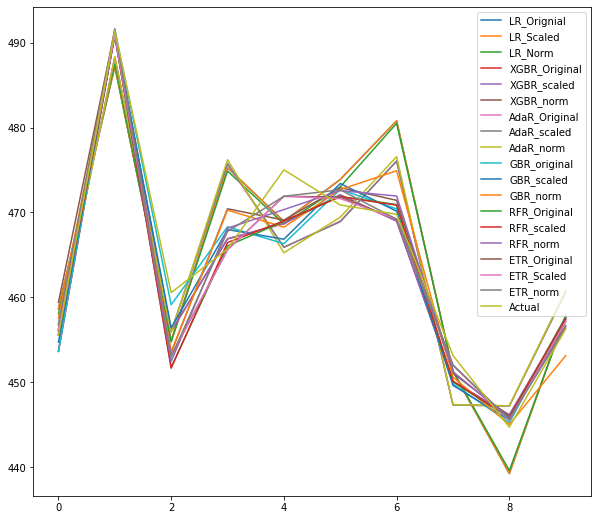

In [ ]:
predictions.head(10).plot.line(figsize=(10,9))

In [ ]:
Errors=pd.DataFrame()
Errors['MeanAbsoluteError']=list(MeanAbsoluteError_dict.values())
Errors['MeanSquaredError']=list(MeanSquaredError_dict.values())
Errors['RootMeanSquaredError']=list(RootMeanSquaredError_dict.values())
Errors['R2Score']=list(R2Score_dict.values())
Errors['TestR2Score']=list(TestR2Score_dict.values())
Errors.index = ['LR_Original','LR_Scaled','LR_Norm',
                'XGB_Original','XGB_Scaled','XGB_Norm',
                'AdaB_Original','AdaB_Scaled','AdaB_Norm',
                'GBR_Original','GBR_Scaled','GBR_Norm',
                'RFR_Original','RFR_Scaled','RFR_Norm',
                'ETR_Original','ETR_Scaled','ETR_Norm']
Errors

,MeanAbsoluteError,MeanSquaredError,RootMeanSquaredError,R2Score,TestR2Score
LR_Original,3.692172,20.746680,4.554852,0.924147,0.927791
LR_Scaled,3.692172,20.746680,4.554852,0.924147,0.927791
LR_Norm,3.669823,20.411617,4.517922,0.925252,0.928957
XGB_Original,1.929607,6.959724,2.638129,0.996905,0.975777
XGB_Scaled,1.929310,6.949850,2.636257,0.996905,0.975811
XGB_Norm,2.264696,9.707503,3.115687,0.994862,0.966213
AdaB_Original,3.938301,24.478677,4.947593,0.918586,0.914802
AdaB_Scaled,3.933974,24.443071,4.943993,0.918662,0.914926
AdaB_Norm,3.923295,24.481269,4.947855,0.918779,0.914793
GBR_Original,2.087747,7.926825,2.815462,0.991553,0.972411


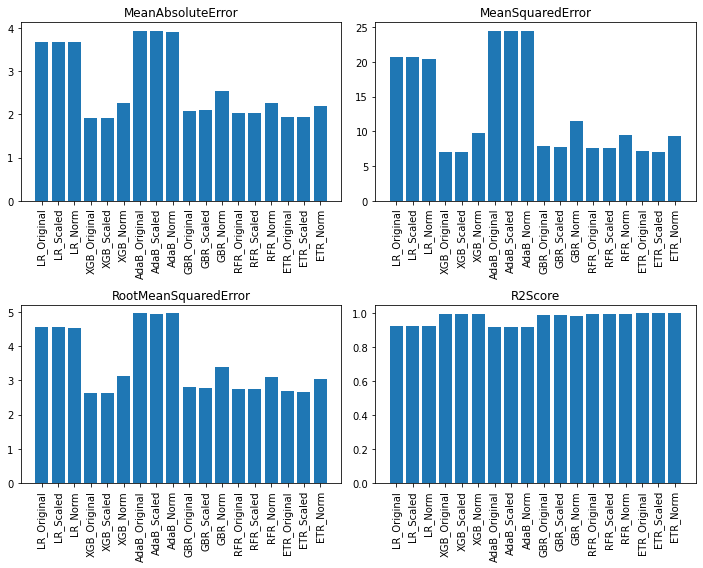

In [ ]:
fig, axis = plt.subplots(2,2,figsize=(10,8))

axis[0,0].bar(Errors.index,Errors['MeanAbsoluteError'])
axis[0,1].bar(Errors.index,Errors['MeanSquaredError'])
axis[1,0].bar(Errors.index,Errors['RootMeanSquaredError'])
axis[1,1].bar(Errors.index,Errors['R2Score'])
axis[0,0].title.set_text('MeanAbsoluteError')
axis[0,1].title.set_text('MeanSquaredError')
axis[1,0].title.set_text('RootMeanSquaredError')
axis[1,1].title.set_text('R2Score')
for tick in axis[0,0].get_xticklabels():
    tick.set_rotation(90)
for tick in axis[0,1].get_xticklabels():
    tick.set_rotation(90)
for tick in axis[1,0].get_xticklabels():
    tick.set_rotation(90)
for tick in axis[1,1].get_xticklabels():
    tick.set_rotation(90)
fig.tight_layout()

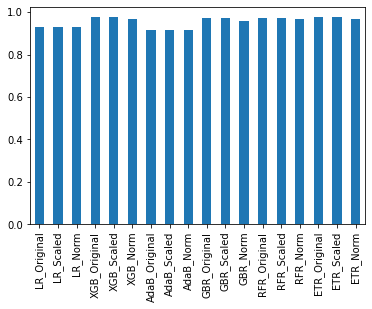

In [ ]:
Errors['TestR2Score'].plot.bar()

# Using the best model for actual predictions

In [ ]:
train_path='/content/drive/My Drive/Projects/Hackathons/Power Plant Energy Prediction/Train.csv'
test_path='/content/drive/My Drive/Projects/Hackathons/Power Plant Energy Prediction/Test.csv'

In [ ]:
train_data=pd.read_csv(train_path)
test_data=pd.read_csv(test_path)

In [ ]:
X_train = train_data.loc[:, train_data.columns != 'PE']
Y_train = train_data['PE']
X_test = test_data

In [ ]:
#Standardizing training data
scaler = preprocessing.StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)

#Standardizing testing data
X_test_scaled=scaler.transform(X_test)

In [ ]:
XGR = xgb.XGBRegressor()
param_grid = {"objective":['reg:squarederror'],
              'colsample_bytree': [0.75,0.8,0.85],
              'learning_rate': [0.005,0.01,0.02],
              'max_depth': [10,15,20], 
              'alpha': [0.01,0.05,0.1], 
              'n_estimators':[3000,5000]}

grid_search = GridSearchCV(estimator = XGR, param_grid = param_grid,cv=3, verbose=2)
XGR_GS = grid_search.fit(X_train, Y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] alpha=0.01, colsample_bytree=0.75, learning_rate=0.005, max_depth=10, n_estimators=3000, objective=reg:squarederror 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  alpha=0.01, colsample_bytree=0.75, learning_rate=0.005, max_depth=10, n_estimators=3000, objective=reg:squarederror, total=  19.6s
[CV] alpha=0.01, colsample_bytree=0.75, learning_rate=0.005, max_depth=10, n_estimators=3000, objective=reg:squarederror 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.6s remaining:    0.0s


[CV]  alpha=0.01, colsample_bytree=0.75, learning_rate=0.005, max_depth=10, n_estimators=3000, objective=reg:squarederror, total=  20.1s
[CV] alpha=0.01, colsample_bytree=0.75, learning_rate=0.005, max_depth=10, n_estimators=3000, objective=reg:squarederror 
[CV]  alpha=0.01, colsample_bytree=0.75, learning_rate=0.005, max_depth=10, n_estimators=3000, objective=reg:squarederror, total=  20.4s
[CV] alpha=0.01, colsample_bytree=0.75, learning_rate=0.005, max_depth=10, n_estimators=5000, objective=reg:squarederror 
[CV]  alpha=0.01, colsample_bytree=0.75, learning_rate=0.005, max_depth=10, n_estimators=5000, objective=reg:squarederror, total=  35.8s
[CV] alpha=0.01, colsample_bytree=0.75, learning_rate=0.005, max_depth=10, n_estimators=5000, objective=reg:squarederror 
[CV]  alpha=0.01, colsample_bytree=0.75, learning_rate=0.005, max_depth=10, n_estimators=5000, objective=reg:squarederror, total=  35.9s
[CV] alpha=0.01, colsample_bytree=0.75, learning_rate=0.005, max_depth=10, n_estimator

[Parallel(n_jobs=1)]: Done 486 out of 486 | elapsed: 389.3min finished


In [ ]:
XGR_GS.best_estimator_

XGBRegressor(alpha=0.01, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.75, gamma=0,
             importance_type='gain', learning_rate=0.02, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=3000,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
Y_pred_XGR = XGR_GS.predict(X_test)

In [ ]:
Y_pred_XGR[0:10]

array([472.33218, 494.81488, 496.88684, 481.01648, 445.5531 , 460.21414,
       455.92822, 463.1073 , 475.9092 , 472.2593 ], dtype=float32)

In [ ]:
type(Y_pred_XGR)

numpy.ndarray

In [ ]:
# Converting an ndarray to csv and saving it
np.savetxt("submission.csv", Y_pred_XGR, delimiter=",",header='PE')